<h1><center>PHYS-F-303: Partie Numérique</center></h1>
<h1><center>Calcul détaillé des propriétés physiques pour le modèle d'Ising</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

## Etude de l'évolution du $\alpha$ critique avec la taille de la grille

In [1]:
import time,pandas
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

### Calcul des paramètres (Magnétisation, Energie, Capacité calorifique)en fonction de $\alpha$ pour différentes tailles de grille

Commençons par importer les fonctions nécessaires, définies dans un fichier séparé.

In [2]:
import Ising_capacalo_jit as Ising

L'initialisation des paramètres de la simulation se fait ici:

In [3]:
NMC = 100+7000 # M et E calculées sur NMC-NMC_eq itérations
NMC_eq = 100
alphas = np.concatenate((np.arange(0.40,0.41,0.005), np.arange(0.41,0.425,0.001) , \
                         np.arange(0.425,0.445,0.0003), np.arange(0.445,0.46,0.001), \
                         np.arange(0.46,0.47,0.005)))

alphasAbove043 = alphas[np.where(alphas>=0.43)]
resolution = 1/(alphasAbove043[1]-alphasAbove043[0])

np.random.shuffle(alphas) # pour avoir des données utilisables en cours de simulation
a = len(alphas)
    
# Affichage des paramètres choisis
print("Number of alphas: {:d}".format(a))
print("NMC per alpha: {:d}".format(NMC-NMC_eq))
print("Resolution close to the transition: 1/{:.3f}".format(resolution))
    
# Estimation du temps de calcul. Estimation propre à une machine particuliere. Pour estimer le temps de calcul sur 
# votre machine, lancer le calcul de la cellule suivante pour un petit nombre d'itération et modifier ce qui suit.
print("Estimated computation time for a 20x20 grid: {:.2f} hours".format(NMC/20000*a/92*1.00))

Number of alphas: 103
NMC per alpha: 7000
Resolution close to the transition: 1/3333.333
Estimated computation time for a 20x20 grid: 0.40 hours


Décommenter et exécuter la cellule suivante lance le calcul complet:

In [4]:
for j in range(2,5):
    
    nx = 20*j
    ny = 20*j
    print("Grid size: {:d}x{:d}".format(nx,ny))
    
    sps = np.empty([a,nx,ny])
    for i in range(a):
        sps[i] = Ising.initial_state_aligned(nx,ny)
    
    start = time.time()
    #[Ms,Es,VarEs] = Ising.M_equilibrium_for_alphas(
    #    sps,nx,ny,NMC,1,alphas,NMC_eq,"dataIsing/new-dataIsing-Res=3333-NMC=7000-N={:d}.csv".format(nx))
    stop = time.time()
    print(stop-start)

Grid size: 40x40
3.337860107421875e-06
Grid size: 60x60
3.5762786865234375e-06
Grid size: 80x80
3.5762786865234375e-06


### Fit des données et recherche du maximum pour N=40

In [5]:
dataIsing = pandas.read_csv("dataIsing/dataIsing-Res=3333-NMC=7000-N=40.csv")
[alphas, Ms, Es, VarEs] = np.transpose(dataIsing.as_matrix(['Couplage', '<Magnetisation>', \
                                                            '<Energie>', 'Var(Energie)']))

indices = np.argsort(alphas)
alphas = alphas[indices]
Ms = Ms[indices]
Es = Es[indices]
VarEs = VarEs[indices]
Cvs = VarEs

nx = 40
ny = 40

Cherchons à la main les paramètres qui définissent une parabole proches du sommet de la courbe sous la forme 

$$ y = A(x-X_0)^2+C $$

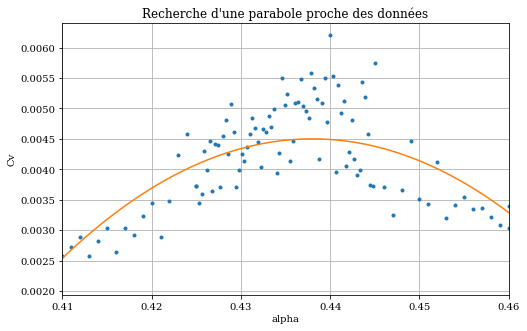

-2.5 0.438 0.0045


In [6]:
A = -2.5
X0 = 0.438
C = 0.0045

x = np.linspace(0.41,0.46,100)
y = A*(x-X0)**2+C

plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.plot(x,y, '-');
plt.title("Recherche d'une parabole proche des données".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('Cv');
plt.xlim([0.41,0.46]);
plt.grid();
plt.show()

print(A,X0,C)

Maintenant que nous savons parmi quels coefficients chercher, nous pouvons automatiser le processus avec une fonction cherchant le meilleur fit par moindres carrés. Dans les cellules qui suivent, nous appelons pour chaque grille une fonction qui réalise l'analyse par moindre carré du sommet de la courbe afin de trouver le $\alpha$ critique.

Cette fonction affiche aussi les paramètres fittant le mieux chaque ensemble de données, ce qui nous permet d'affiner l'ensemble de paramètres test original utilisé. 

La fonction calcule l'erreur sur ce qu'elle renvoie en répétant plusieurs fois le calcul sur les données bruitée avec un bruit d'amplitude plausible, i.e. semblable à la variance des données et en regardant la variance des résultats (erreur statistique), ainsi qu'en tenant compte de la résolution utilisée dans les paramètres test (erreur numérique).

Les paramètres test sont bien choisi si l'erreur numérique liée à la finesse de l'échantillonage est petite comparée à l'erreur statistique sur les données récoltées. Ainsi, nous en arrivons à utiliser les paramètres test implémentés dans cette fonction.

Importons la procédure de calcul du alpha critique par la méthode des moindres carrés appliqué à un fit parabolique du sommet de la courbe de la capacité calorifique.

In [7]:
import Least_Squares

Appliquons-la à nos données pour trouver le alpha maximisant la capacité calorifique pour chaque grille de spin étudiée.

In [8]:
A_test  = np.linspace(-5.0,0,11)
X0_test = np.linspace(0.432,0.442,201) # paramètre le plus pertinent -> plus de points
C_test  = np.linspace(0.003,0.006,11)

[alphas_max, err_alphas_max] = \
    Least_Squares.moindres_carres_avec_erreur("dataIsing/dataIsing-Res=3333-NMC=7000-N=40.csv",A_test,X0_test,C_test)

Best fitting parameters: -4.0000 0.4374 0.0048
Le maximum de la parabole de fit se trouve en alpha = 0.43735 +- 0.00021
Erreur numérique: 0.00005 - Erreur Statistique: 0.00020
--------------------------------------------------------------------


### Fit des données et recherche du maximum pour N=60

In [9]:
dataIsing = pandas.read_csv("dataIsing/dataIsing-Res=3333-NMC=7000-N=60.csv")
[alphas, Ms, Es, VarEs] = np.transpose(dataIsing.as_matrix(['Couplage', '<Magnetisation>', \
                                                            '<Energie>', 'Var(Energie)']))

indices = np.argsort(alphas)
alphas = alphas[indices]
Ms = Ms[indices]
Es = Es[indices]
VarEs = VarEs[indices]
Cvs = VarEs

nx = 60
ny = 60

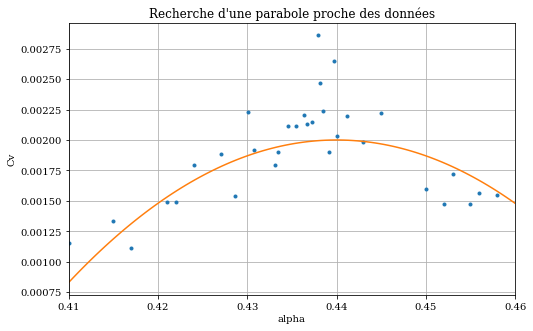

-1.3 0.44 0.002


In [10]:
A = -1.3
X0 = 0.44
C = 0.0020

x = np.linspace(0.41,0.46,100)
y = A*(x-X0)**2+C

plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.plot(x,y, '-');
plt.title("Recherche d'une parabole proche des données".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('Cv');
plt.xlim([0.41,0.46]);
plt.grid();
plt.show()

print(A,X0,C)

In [11]:
A_test  = np.linspace(-3.0,1,11)
X0_test = np.linspace(0.434,0.444,201) # paramètre le plus pertinent -> plus de points
C_test  = np.linspace(0.0005,0.0035,11)

[alphas_max, err_alphas_max] = \
    Least_Squares.moindres_carres_avec_erreur("dataIsing/dataIsing-Res=3333-NMC=7000-N=60.csv",A_test,X0_test,C_test)

Best fitting parameters: -2.6000 0.4382 0.0023
Le maximum de la parabole de fit se trouve en alpha = 0.43820 +- 0.00060
Erreur numérique: 0.00005 - Erreur Statistique: 0.00060
--------------------------------------------------------------------


### Fit des données et recherche du maximum pour N=80

In [12]:
dataIsing = pandas.read_csv("dataIsing/dataIsing-Res=1000-NMC=7000-N=80.csv")
[alphas, Ms, Es, VarEs] = np.transpose(dataIsing.as_matrix(['Couplage', '<Magnetisation>', \
                                                            '<Energie>', 'Var(Energie)']))

indices = np.argsort(alphas)
alphas = alphas[indices]
Ms = Ms[indices]
Es = Es[indices]
VarEs = VarEs[indices]
Cvs = VarEs

nx = 80
ny = 80

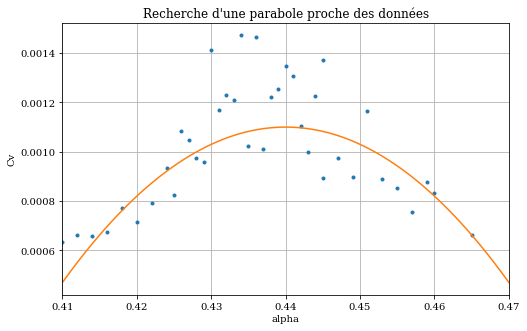

-0.7 0.44 0.0011


In [13]:
A = -0.7
X0 = 0.44
C = 0.0011

x = np.linspace(0.41,0.47,100)
y = A*(x-X0)**2+C

plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.plot(x,y, '-');
plt.title("Recherche d'une parabole proche des données".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('Cv');
plt.xlim([0.41,0.47]);
plt.grid();
plt.show()

print(A,X0,C)

In [14]:
A_test  = np.linspace(-2.0,0,11)
X0_test = np.linspace(0.434,0.444,201) # paramètre le plus pertinent -> plus de points
C_test  = np.linspace(0.002,0.0005,11)

[alphas_max, err_alphas_max] = \
    Least_Squares.moindres_carres_avec_erreur("dataIsing/dataIsing-Res=1000-NMC=7000-N=80.csv",A_test,X0_test,C_test)

Best fitting parameters: -1.2000 0.4379 0.0013
Le maximum de la parabole de fit se trouve en alpha = 0.43785 +- 0.00095
Erreur numérique: 0.00005 - Erreur Statistique: 0.00095
--------------------------------------------------------------------


### Conclusions

Les valeurs de $\alpha$ critique récoltées avec ce notebook sont avec celle pour $N=20$ obtenue précédemment:

| N | alpha |
|---|-------|
| 20 | 0.4336(10) |
| 40 | 0.4374(2) |
| 60 | 0.4382(6) |
| 80 | 0.4379(10) |

Il est à noter que les erreurs sur les valeurs calculées dans ce notebook ne tiennent pas compte de la corrélation des spins, étant donné que nous avons fait le calcul pour une seule grille à chaque fois.

Les valeurs de $\alpha$ critique pour $N=40,60$ et $80$ sont très proches les unes des autres, la valeur pour $N=80$ étant même plus petite que celle obtenue pour $N=60$. Cela doit être dû à la faible quantité de données récoltées pour ces grilles. En effet, nous pouvons voir que les erreurs sur es dernières valeurs sont de l'ordre de la séparation entre celles-ci. 

Nous voyons malgré cela que les valeurs obtenues pour $N=40,60,80$ sont nettement plus proches de la valeur limite théorique de $0.441$ pour $N\rightarrow\infty$. Cependant l'écart entre $0.441$ et le groupement de valeurs pour $N=40,60,80$ est trop grand pour vérifier que notre algorithme tend vers la bonne valeur. Effectivement, tout ce que nous pouvons conclure à ce stade est que soit la méthode converge lentement en agrandissant la grille, soit elle converge rapidement vers une valeur autre que $0.441$, localisée aux alentours de $0.438$.